In [28]:
import os
from pathlib import Path
from typing import Callable, Optional, Union
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import arviz as az

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import encode_distance_setting, encode_number_of_objects
from src.helpers import compute_dprime, compute_criterion

In [29]:
# optionally add graphviz to PATH
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

## Load Data

In [30]:
path_all = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'cleaned_shape_experiment_1.csv'  # all data, cleaned up for SDT
path_sum = Path(os.getcwd()).parent / 'data' / 'processed_data' / 'hit_fa_summary_shape_experiment_1.csv' # summary DataFrame

In [31]:
df = pd.read_csv(path_all)
summary = pd.read_csv(path_sum)

In [32]:
df.shape

(14800, 22)

In [33]:
df.head(2)

,participant,distance_setting,number_of_objects,trial_number,target_present,ran,order,response_yes,yes_no_correct,hit,...,rt_where_sec,response_where_x,response_where_y,target_pos_x,target_pos_y,click_distance_deg,distance_shapecomp,background_shape_idx,proto_object_idx,date_str
0,SR,low,3,1,False,1.0,0.0,0.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-1.0,2023-06-26_15h38.26.579
1,SR,low,3,2,True,1.0,1.0,1.0,1.0,1,...,0.303415,-2.645458,-6.242093,-5.434043,-1.889708,5.169086,0.514986,0.0,39.0,2023-06-26_15h38.26.579


In [34]:
summary.shape

(146, 10)

In [35]:
summary.head(2)

,participant,distance_setting,number_of_objects,n_hit,n_fa,n_signal,n_noise,proportion_correct,hit_rate,false_alarm_rate
0,DB,high,2,46,5,50,50,0.91,0.903846,0.115385
1,DB,high,3,47,2,50,50,0.95,0.923077,0.057692


In [36]:
df['distance_setting_code']  = encode_distance_setting(df['distance_setting'])
df['number_of_objects_code'] = encode_number_of_objects(df['number_of_objects'])

summary['distance_setting_code']  = encode_distance_setting(summary['distance_setting'])
summary['number_of_objects_code'] = encode_number_of_objects(summary['number_of_objects'])

print('distance_setting_code' in df.columns      and 'number_of_objects_code' in df.columns)
print('distance_setting_code' in summary.columns and 'number_of_objects_code' in summary.columns)

True
True


Compute point estimates for $ d' $ and $ \lambda $

In [37]:
summary['dprime'] = compute_dprime(summary['hit_rate'], summary['false_alarm_rate'])
summary['lambda'] = compute_criterion(summary['false_alarm_rate'])

summary[['dprime', 'lambda']].describe()

,dprime,lambda
count,146.000000,146.000000
mean,1.621773,1.065357
std,0.914764,0.470423
min,-1.018592,-0.344102
25%,0.868500,0.801095
50%,1.572630,1.020076
75%,2.301287,1.426077
max,4.139804,2.069902


Aggregate the mean values of point estimates over participants.

In [110]:
agg = summary[['participant', 'dprime', 'lambda']].groupby('participant').mean().reset_index()
agg['source'] = 'point estimate'
agg

,participant,dprime,lambda,source
0,DB,1.886095,1.178822,point estimate
1,DH,2.103627,1.465888,point estimate
2,HT,1.212493,0.787418,point estimate
3,JH,2.064833,1.203469,point estimate
4,JT,0.749604,0.659423,point estimate
5,MG,2.098477,1.367856,point estimate
6,NS,1.243468,0.861502,point estimate
7,OF,2.045580,1.562632,point estimate
8,RS,1.172838,0.552935,point estimate
9,SR,1.568548,0.918706,point estimate


Add numerical codes for each participant. These values will be used in the modeling step.

In [38]:
participant_encoder = LabelEncoder()
df['participant_code'] = participant_encoder.fit_transform(df['participant'].values)

print('participant_code' in df.columns)

True


## GLMM

In [105]:
def glmm(participant_code : jnp.ndarray, target_present : jnp.ndarray, response_yes : Optional[jnp.ndarray] = None) -> None:
    # sample intercept parameters
    mu_0    = numpyro.sample('mu_0',    dist.Normal(0, 5))
    sigma_0 = numpyro.sample('sigma_0', dist.HalfNormal(5))

    # sample slope parameters
    mu_1    = numpyro.sample('mu_1',    dist.Normal(0, 5))
    sigma_1 = numpyro.sample('sigma_1', dist.HalfNormal(5))

    n_participants = jnp.unique(participant_code, size=10).size

    with numpyro.plate('participants', n_participants):
        beta_0 = numpyro.sample('beta_0', dist.Normal(mu_0, sigma_0))
        beta_1 = numpyro.sample('beta_1', dist.Normal(mu_1, sigma_1))
    
    eta = numpyro.deterministic('eta', beta_0[participant_code] + beta_1[participant_code] * target_present)
    p   = dist.Normal().cdf(eta)
    
    with numpyro.plate('data', size=target_present.size):
        numpyro.sample('obs', dist.Bernoulli(probs=p), obs=response_yes)

def run_glmm():
    """
    Encapsulates the code for fitting a GLMM.
    """
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(glmm)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
    mcmc.run(
        rng_key_, 
        participant_code=jnp.asarray(df['participant_code'].values).astype(int),
        target_present=jnp.asarray(df['target_present'].values).astype(int),
        response_yes=jnp.asarray(df['response_yes'].values).astype(int)
    )
    mcmc.print_summary()
    return mcmc

In [201]:
df.columns

Index(['participant', 'distance_setting', 'number_of_objects', 'trial_number',
       'target_present', 'ran', 'order', 'response_yes', 'yes_no_correct',
       'hit', 'false_alarm', 'rt_sec', 'rt_where_sec', 'response_where_x',
       'response_where_y', 'target_pos_x', 'target_pos_y',
       'click_distance_deg', 'distance_shapecomp', 'background_shape_idx',
       'proto_object_idx', 'date_str', 'distance_setting_code',
       'number_of_objects_code', 'participant_code'],
      dtype='object')

In [232]:
def create_empty_rows(p, d, n):
    empty_df = pd.DataFrame.from_dict({col : [np.nan] * 100 for col in df.columns if col not in ['participant', 'distance_setting', 'number_of_objects']})
    empty_df['participant'] = p
    empty_df['distance_setting'] = d
    empty_df['number_of_objects'] = n
    return empty_df

def clean_up_data():
    clean_df = df.copy(deep=True)
    new_data = []

    for p in clean_df['participant'].unique():
        subset = clean_df[clean_df['participant'] == p]
        if len(subset) != 3 * 5 * 100:
            for d in subset['distance_setting'].unique():
                for n in subset['number_of_objects'].unique():
                    data = subset.loc[(subset['distance_setting'] == d) & (subset['number_of_objects'] == n), :]
                    if data.shape[0] > 100:
                        clean_df.drop(index=data.index[100:], inplace=True)
                    elif data.shape[0] < 100:
                        new_data.append(create_empty_rows(p, d, n))
    
    return pd.concat([clean_df] + new_data, axis=0)

def check_df(df : pd.DataFrame):
    clean_df = df.copy(deep=True)
    new_data = []

    for p in clean_df['participant'].unique():
        subset = clean_df[clean_df['participant'] == p]
        if len(subset) != 3 * 5 * 100:
            for d in subset['distance_setting'].unique():
                for n in subset['number_of_objects'].unique():
                    data = subset.loc[(subset['distance_setting'] == d) & (subset['number_of_objects'] == n), :]
                    if data.shape[0] > 100:
                        return False
                    elif data.shape[0] < 100:
                        return False
    
    return True
                            
check_df(clean_up_data())

clean_up_data().sort_values(by=['participant', 'distance_setting', 'number_of_objects'])

,participant,distance_setting,number_of_objects,trial_number,target_present,ran,order,response_yes,yes_no_correct,hit,...,target_pos_x,target_pos_y,click_distance_deg,distance_shapecomp,background_shape_idx,proto_object_idx,date_str,distance_setting_code,number_of_objects_code,participant_code
800,DB,high,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1.0,-1.0,2023-06-27_14h13.26.121,1.0,1.0,0.0
801,DB,high,2,2.0,0.0,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,1.0,-1.0,2023-06-27_14h13.26.121,1.0,1.0,0.0
802,DB,high,2,3.0,0.0,1.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,1.0,-1.0,2023-06-27_14h13.26.121,1.0,1.0,0.0
803,DB,high,2,4.0,0.0,1.0,3.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,1.0,-1.0,2023-06-27_14h13.26.121,1.0,1.0,0.0
804,DB,high,2,5.0,1.0,1.0,4.0,1.0,1.0,1.0,...,5.071198,-3.456182,0.384929,1.497311,0.0,20.0,2023-06-27_14h13.26.121,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,SR,mid,16,96.0,0.0,1.0,95.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,15.0,-1.0,2023-06-26_16h11.41.539,2.0,5.0,9.0
1996,SR,mid,16,97.0,0.0,1.0,96.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,15.0,-1.0,2023-06-26_16h11.41.539,2.0,5.0,9.0
1997,SR,mid,16,98.0,0.0,1.0,97.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,15.0,-1.0,2023-06-26_16h11.41.539,2.0,5.0,9.0
1998,SR,mid,16,99.0,0.0,1.0,98.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,15.0,-1.0,2023-06-26_16h11.41.539,2.0,5.0,9.0


In [40]:
run_glmm()

  0%|          | 0/3000 [00:00<?, ?it/s]

sample: 100%|██████████| 3000/3000 [00:34<00:00, 86.45it/s, 15 steps of size 3.03e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta_0[0]     -1.21      0.06     -1.21     -1.31     -1.10   1770.67      1.00
 beta_0[1]     -1.50      0.07     -1.50     -1.61     -1.38   1758.81      1.00
 beta_0[2]     -0.79      0.05     -0.79     -0.88     -0.71   1842.09      1.00
 beta_0[3]     -1.21      0.06     -1.21     -1.31     -1.12   2019.79      1.00
 beta_0[4]     -0.65      0.05     -0.65     -0.73     -0.57   1704.93      1.00
 beta_0[5]     -1.40      0.07     -1.40     -1.51     -1.29   1927.40      1.00
 beta_0[6]     -0.88      0.05     -0.88     -0.95     -0.79   1905.00      1.00
 beta_0[7]     -1.61      0.07     -1.61     -1.73     -1.50   2496.69      1.00
 beta_0[8]     -0.59      0.05     -0.59     -0.67     -0.51   1771.49      1.00
 beta_0[9]     -0.91      0.05     -0.91     -0.99     -0.83   1867.06      1.00
 beta_1[0]      1.86      0.08      1.86      1.73      1.99   1763.54      1.00
 beta_1[1]      2.02      0

### Model Comparison

Compare the pooled model with the unpooled model as well as with the point estimates.

In [103]:
def glm(
    target_present : jnp.ndarray, 
    response_yes : Optional[jnp.ndarray] = None
) -> None:
    """
    Fits an equal variance gaussian SDT model based on a probit GLM to the data.
    For discussion, see DeCarlo (1998).

    Parameters:
        target_present : jnp.ndarray
            For each trial, whether the trial contained a target.
            Each value can be 0 or 1.
        response_yes   : jnp.ndarray
            For each trial, whether the participant responded yes on the yes-no task.
            Each value can be 0 or 1.
    Returns
        None
    """
    # intercept aka criterion
    beta_0 = numpyro.sample('beta_0', dist.Normal(0, 5))

    # coefficient aka d'
    beta_1 = numpyro.sample('beta_1', dist.Normal(0, 5))
    
    with numpyro.plate(name='data', size=target_present.size):
        # linear predictor
        eta = numpyro.deterministic(name='eta', value=beta_0 + beta_1 * target_present)

        # probit link
        p = dist.Normal().cdf(eta)
        
        numpyro.sample('obs', dist.Bernoulli(probs=p), obs=response_yes)

def run_glm(participant : str):
    """
    Runs the GLM for a particular participant.

    Parameters:
        participant : str
            The participant, whose data is used to fit the GLM.

    Returns:
        mcmc : MCMC
            The MCMC objects that contains model parameters.
    """
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(glm)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
    mcmc.run(
        rng_key_,
        target_present=jnp.asarray(df[df['participant'] == participant]['target_present'].values).astype(int),
        response_yes=jnp.asarray(df[df['participant'] == participant]['response_yes'].values).astype(int),
    )
    mcmc.print_summary()
    return mcmc

In [127]:
def compute_unpooled_model_coefficients(df : pd.DataFrame, summary_df : pd.DataFrame) -> pd.DataFrame:
    """
    Computes the values of dprime and lambda that result from fitting a separate GLM for each participant in the DataFrame.

    Parameters:
        df : pd.DataFrame
            The DataFrame that contains the data to fit the model.
        summary_df : pd.DataFrame
            The DataFrame that contains the results of point estimation for each participant.
    
    Returns:
        model_df : pd.DataFrame
            The DataFrame containing the values for d' and lambda.
    """
    cs = []
    ds = []
    for participant in summary_df['participant']:
        model = run_glm(participant)
        model_summary = numpyro.diagnostics.summary(model.get_samples(group_by_chain=True))
        cs.append(-model_summary['beta_0']['mean'])
        ds.append(model_summary['beta_1']['mean'])

    model_df = pd.DataFrame.from_dict({
        'participant' : summary_df['participant'].values,
        'dprime' : ds,
        'lambda' : cs,
        'source' : ['unpooled model'] * len(summary_df),
    })

    return model_df

In [128]:
unpooled_df = compute_unpooled_model_coefficients(df, agg)
unpooled_df

sample: 100%|██████████| 3000/3000 [00:07<00:00, 382.57it/s, 3 steps of size 5.23e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -1.22      0.06     -1.22     -1.32     -1.12    430.14      1.00
    beta_1      1.87      0.08      1.87      1.75      2.01    488.11      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:08<00:00, 368.61it/s, 7 steps of size 3.84e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -1.53      0.07     -1.53     -1.64     -1.41    605.81      1.00
    beta_1      2.05      0.08      2.05      1.91      2.18    603.86      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 389.23it/s, 15 steps of size 5.53e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -0.79      0.05     -0.79     -0.87     -0.70    597.58      1.00
    beta_1      1.16      0.07      1.16      1.06      1.28    597.23      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 396.67it/s, 3 steps of size 6.07e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -1.22      0.06     -1.22     -1.32     -1.11    509.63      1.00
    beta_1      1.99      0.08      1.99      1.86      2.12    530.84      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 400.94it/s, 15 steps of size 5.73e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -0.63      0.05     -0.63     -0.72     -0.55    568.57      1.00
    beta_1      0.72      0.07      0.72      0.62      0.83    610.15      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 419.57it/s, 3 steps of size 5.80e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -1.42      0.07     -1.42     -1.53     -1.31    553.55      1.00
    beta_1      2.00      0.08      2.00      1.87      2.14    565.86      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 412.15it/s, 1 steps of size 5.09e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -0.87      0.05     -0.87     -0.96     -0.79    646.45      1.00
    beta_1      1.25      0.07      1.25      1.13      1.35    739.17      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 394.01it/s, 3 steps of size 4.51e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -1.65      0.08     -1.65     -1.78     -1.52    562.82      1.00
    beta_1      2.04      0.09      2.04      1.90      2.19    618.48      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 410.15it/s, 7 steps of size 5.11e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -0.59      0.05     -0.59     -0.67     -0.50    671.88      1.00
    beta_1      1.16      0.07      1.16      1.05      1.28    679.97      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:07<00:00, 419.17it/s, 3 steps of size 5.76e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -0.91      0.05     -0.91     -1.00     -0.82    552.50      1.00
    beta_1      1.48      0.07      1.48      1.37      1.61    576.27      1.00

Number of divergences: 0


,participant,dprime,lambda,source
0,DB,1.874752,1.215366,unpooled model
1,DH,2.053127,1.526990,unpooled model
2,HT,1.162805,0.790548,unpooled model
3,JH,1.993286,1.223821,unpooled model
4,JT,0.723979,0.634159,unpooled model
5,MG,2.003188,1.418323,unpooled model
6,NS,1.246597,0.871822,unpooled model
7,OF,2.037430,1.645220,unpooled model
8,RS,1.158034,0.585673,unpooled model
9,SR,1.484450,0.909900,unpooled model


In [131]:
def compute_pooled_model_coefficients(df : pd.DataFrame, summary_df : pd.DataFrame, participant_encoder : LabelEncoder) -> pd.DataFrame:
    """
    Computes the values of dprime and lambda that result from fitting a separate GLM for each participant in the DataFrame.

    Parameters:
        df : pd.DataFrame
            The DataFrame that contains the data to fit the model.
        summary_df : pd.DataFrame
            The DataFrame that contains the results of point estimation for each participant.
        participant_encoder : LabelEncoder
            The encoder that was used to perform numerical encoding of participant labels.
        
    Returns:
        model_df : pd.DataFrame
            The DataFrame containing the values for d' and lambda.
    """
    model = run_glmm()
    model_summary = numpyro.diagnostics.summary(model.get_samples(group_by_chain=True))

    cs = -model_summary['beta_0']['mean'][participant_encoder.transform(summary_df['participant'])]
    ds = model_summary['beta_1']['mean'][participant_encoder.transform(summary_df['participant'])]

    model_df = pd.DataFrame.from_dict({
        'participant' : summary_df['participant'],
        'dprime' : ds,
        'lambda' : cs,
        'source' : ['pooled model'] * len(summary_df),
    })

    return model_df

In [132]:
pooleed_df = compute_pooled_model_coefficients(df, agg, participant_encoder)
pooleed_df

sample: 100%|██████████| 3000/3000 [00:34<00:00, 88.14it/s, 15 steps of size 3.03e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta_0[0]     -1.21      0.06     -1.21     -1.31     -1.10   1770.67      1.00
 beta_0[1]     -1.50      0.07     -1.50     -1.61     -1.38   1758.81      1.00
 beta_0[2]     -0.79      0.05     -0.79     -0.88     -0.71   1842.09      1.00
 beta_0[3]     -1.21      0.06     -1.21     -1.31     -1.12   2019.79      1.00
 beta_0[4]     -0.65      0.05     -0.65     -0.73     -0.57   1704.93      1.00
 beta_0[5]     -1.40      0.07     -1.40     -1.51     -1.29   1927.40      1.00
 beta_0[6]     -0.88      0.05     -0.88     -0.95     -0.79   1905.00      1.00
 beta_0[7]     -1.61      0.07     -1.61     -1.73     -1.50   2496.69      1.00
 beta_0[8]     -0.59      0.05     -0.59     -0.67     -0.51   1771.49      1.00
 beta_0[9]     -0.91      0.05     -0.91     -0.99     -0.83   1867.06      1.00
 beta_1[0]      1.86      0.08      1.86      1.73      1.99   1763.54      1.00
 beta_1[1]      2.02      0

,participant,dprime,lambda,source
0,DB,1.860218,1.206321,pooled model
1,DH,2.020564,1.500946,pooled model
2,HT,1.167540,0.794649,pooled model
3,JH,1.977528,1.214454,pooled model
4,JT,0.739251,0.646044,pooled model
5,MG,1.976648,1.398019,pooled model
6,NS,1.251393,0.876121,pooled model
7,OF,1.996557,1.609688,pooled model
8,RS,1.169738,0.594921,pooled model
9,SR,1.483237,0.910541,pooled model


### Plot Model Coefficients in the Cartesian Space

In [134]:
comparison_df = pd.concat([agg, unpooled_df, pooleed_df], axis=0)
comparison_df[comparison_df['participant'] == 'DH']

,participant,dprime,lambda,source
1,DH,2.103627,1.465888,point estimate
1,DH,2.053127,1.526990,unpooled model
1,DH,2.020564,1.500946,pooled model


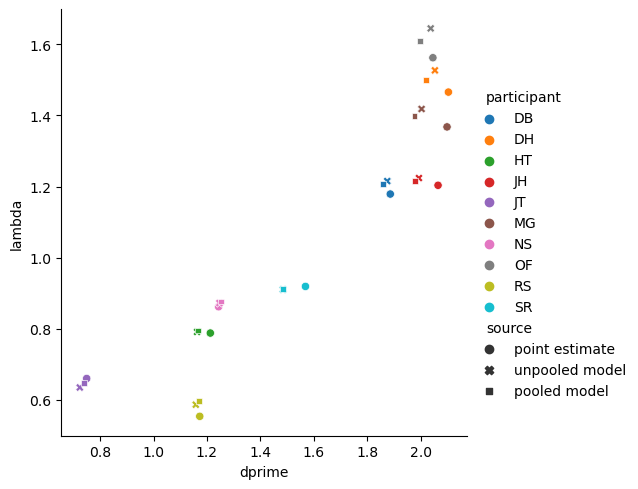

In [135]:
sns.relplot(
    data=comparison_df,
    x='dprime',
    y='lambda',
    hue='participant',
    style='source',
)